## Merchant Revenue Analysis
This notebook examines expected revenue by merchant, incorporating expected losses due to frau
### Load constants and libraries
First of all we load any constant values for use within the notebook, load any libraries required, and initiate a spark object. 

In [6]:
# import all constants and custome functions used in the note books
import sys
sys.path.append('../scripts/utils')
from constants import *
from custom_functions import *

# libraries required
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import pandas as pd

import matplotlib.pyplot as plt

# plot configuration
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["axes.titleweight"] = "normal"

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/10/18 16:20:27 WARN Utils: Your hostname, DESKTOP-VP2PCTV resolves to a loopback address: 127.0.1.1; using 172.21.252.215 instead (on interface eth0)
23/10/18 16:20:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/18 16:20:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Examine the Revenue Data

First of all we look at the distribution for the merchant revenue data

In [7]:
# load up the data sets for use in the notebook

transaction_data = spark.read.parquet(f'{TRANSACTION_DATA}')
consumer_fraud = spark.createDataFrame(pd.read_pickle(f"{CURATED_DATA}consumer_fraud_full.pkl"))
#consumer_fraud = consumer_fraud.withColumn("order_datetime",F.to_date(F.col("order_datetime")))
merchants = spark.createDataFrame(pd.read_pickle(f"{CURATED_DATA}tbl_merchants.pkl")[[
    "merchant_abn", "take_rate"]])

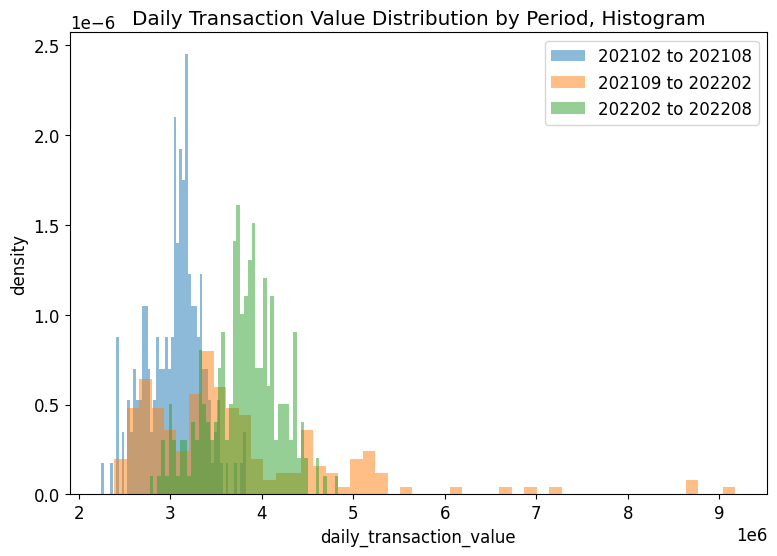

In [8]:
# checking for different regimes which may drive the "mixture model" described in the fraud notebook

# split the data into the 3 different subsets
transaction_daily = transaction_data.groupBy("order_datetime").agg(
    F.sum("dollar_value").alias("daily_value_traded"),
    F.count(F.col("order_datetime")).alias("num_daily_trades")
).toPandas()
transaction_daily["order_datetime"] = pd.to_datetime(transaction_daily["order_datetime"], format='%Y-%m-%d')
transaction_daily["202102_to_202108"] = transaction_daily.loc[transaction_daily["order_datetime"]<="2021-08-27","daily_value_traded"]
transaction_daily["202109_to_202202"] = transaction_daily.loc[(transaction_daily["order_datetime"]>"2021-08-27") & 
                                                              (transaction_daily["order_datetime"]<="2022-02-27"), "daily_value_traded"]
transaction_daily["202202_to_202208"] = transaction_daily.loc[transaction_daily["order_datetime"]>"2022-02-27","daily_value_traded"]

# plot the results
plt.figure(figsize=(9, 6))
plt.hist(list(transaction_daily["202102_to_202108"]), bins=50, alpha=0.5, label="202102 to 202108", density=True)
plt.hist(list(transaction_daily["202109_to_202202"]), bins=50, alpha=0.5, label="202109 to 202202", density=True)
plt.hist(list(transaction_daily["202202_to_202208"]), bins=50, alpha=0.5, label="202202 to 202208", density=True)
plt.title('Daily Transaction Value Distribution by Period, Histogram')
plt.xlabel('daily_transaction_value')
plt.ylabel('density')
#plt.ylabel('count')
plt.legend()
plt.savefig(f'{PLOTS}rev_data.png', bbox_inches='tight')
plt.show()

It can be seen that the Feb 2021 - Aug 2021 and Feb 2022 - Aug 2022 regimes are similar, though the overall transaction values in 2022 were higher. THe Sep 2021 - Feb 2022 regime is markedly different.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


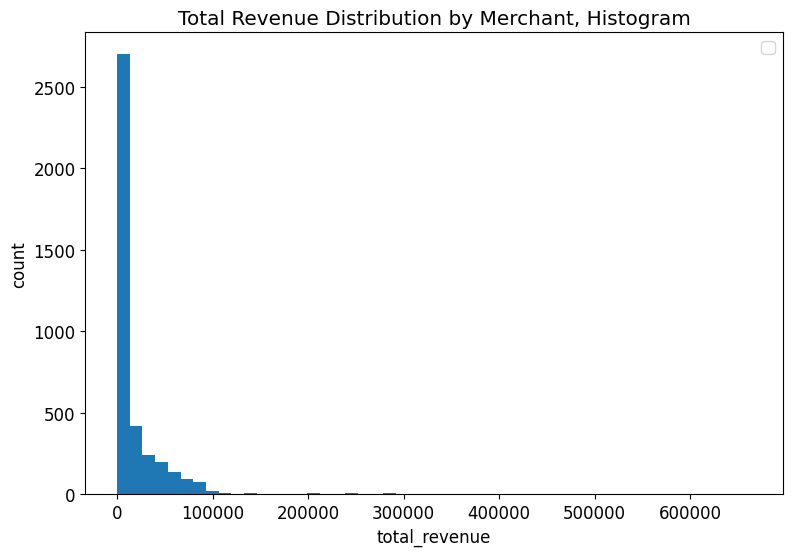

In [9]:
# look at the distribution of total revenue by merchant

merchant_revenue = transaction_data.groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('total_revenue')
)
merchant_revenue = merchant_revenue.join(merchants, on=["merchant_abn"], how="inner").toPandas()

# for simplicity it is assumed that all of the merchant revenue goes through the BNPL firm
merchant_revenue['total_revenue'] = merchant_revenue['total_revenue'] * merchant_revenue['take_rate']/100
merchant_revenue.to_pickle(f"{ANALYSIS_DATA}merchant_revenue.pkl") 

plt.figure(figsize=(9, 6))
plt.hist(list(merchant_revenue["total_revenue"]), bins=50, density=False)
plt.title('Total Revenue Distribution by Merchant, Histogram')
plt.xlabel('total_revenue')
plt.ylabel('count')
plt.legend()
#plt.savefig(f'{PLOTS}merchant_rev1.png', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


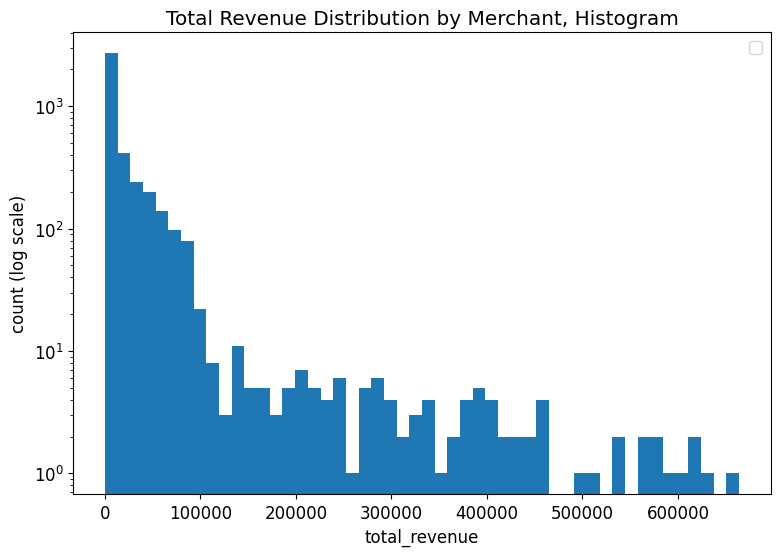

In [10]:
# convert to log-scale

plt.figure(figsize=(9, 6))
plt.hist(list(merchant_revenue["total_revenue"]), bins=50, density=False, log=True)
plt.title('Total Revenue Distribution by Merchant, Histogram')
plt.xlabel('total_revenue')
plt.ylabel('count (log scale)')
plt.legend()
plt.savefig(f'{PLOTS}merchant_rev1_log.png', bbox_inches='tight')
plt.show()

The distribution of total revenue by merchant seems to follow some form of power law, similar to fraud probability

### Adjusting Revenue for Fraud Probability

Next we calculate the expected revenue per merchant by deducting a loss for expected fraud, which is simply calculated as the fraud probability * transaction value, for all transactions. Total expected profitability per merchant = total transaction value * take rate - fraud probability * transaction value (for all transactions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


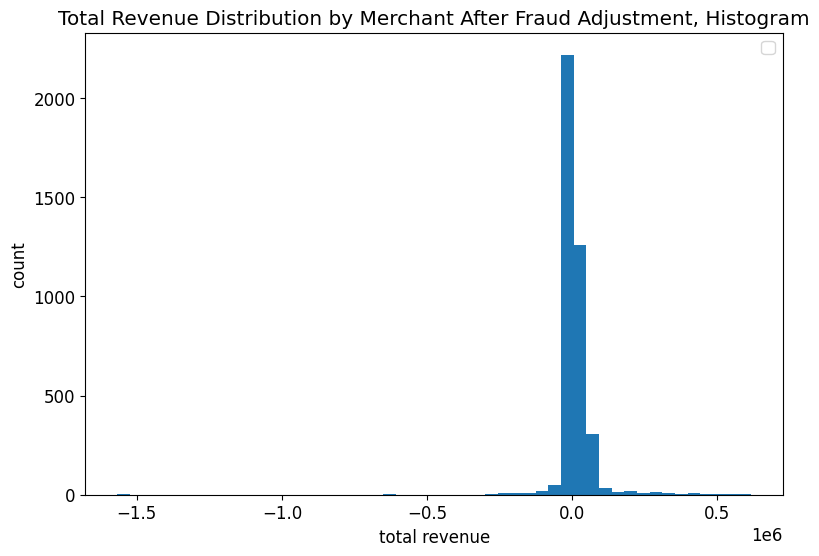

In [11]:
# add fraud probability to transactions, and set to zero if missing
transactions_fraud = transaction_data.join(consumer_fraud, on=["user_id", "order_datetime"], how="left")
transactions_fraud = transactions_fraud.fillna(0, subset=['fraud_probability'])
# add merchant take rates
transactions_fraud = transactions_fraud.join(merchants, on=["merchant_abn"], how="inner")
# calculate take rate per transaction
transactions_fraud = transactions_fraud.withColumn('take_revenue',
                       transactions_fraud.dollar_value * transactions_fraud.take_rate/100)
# calculate fraud cost per transaction
transactions_fraud = transactions_fraud.withColumn('fraud_cost',
                       transactions_fraud.dollar_value * transactions_fraud.fraud_probability/100)
# calculate net revenue per transactions
transactions_fraud = transactions_fraud.withColumn('net_revenue',
                       transactions_fraud.take_revenue - transactions_fraud.fraud_cost)

merchant_revenue_fraud = transactions_fraud.groupBy('merchant_abn').agg(
    F.sum('net_revenue').alias('total_revenue')
).toPandas()

merchant_revenue_fraud.to_pickle(f"{ANALYSIS_DATA}merchant_revenue_fraud.pkl") 

plt.figure(figsize=(9, 6))
plt.hist(list(merchant_revenue_fraud["total_revenue"]), bins=50, density=False)
plt.title('Total Revenue Distribution by Merchant After Fraud Adjustment, Histogram')
plt.xlabel('total revenue')
plt.ylabel('count')
plt.legend()
#plt.savefig(f'{PLOTS}merchant_rev2.png', bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


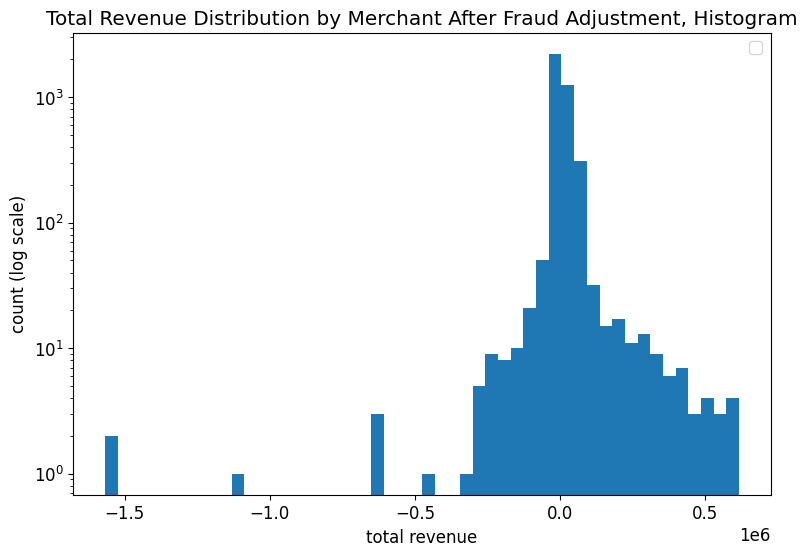

In [12]:
# convert to log-scale
plt.figure(figsize=(9, 6))
plt.hist(list(merchant_revenue_fraud["total_revenue"]), bins=50, density=False, log=True)
plt.title('Total Revenue Distribution by Merchant After Fraud Adjustment, Histogram')
plt.xlabel('total revenue')
plt.ylabel('count (log scale)')
plt.legend()
plt.savefig(f'{PLOTS}merchant_rev2_log.png', bbox_inches='tight')
plt.show() 

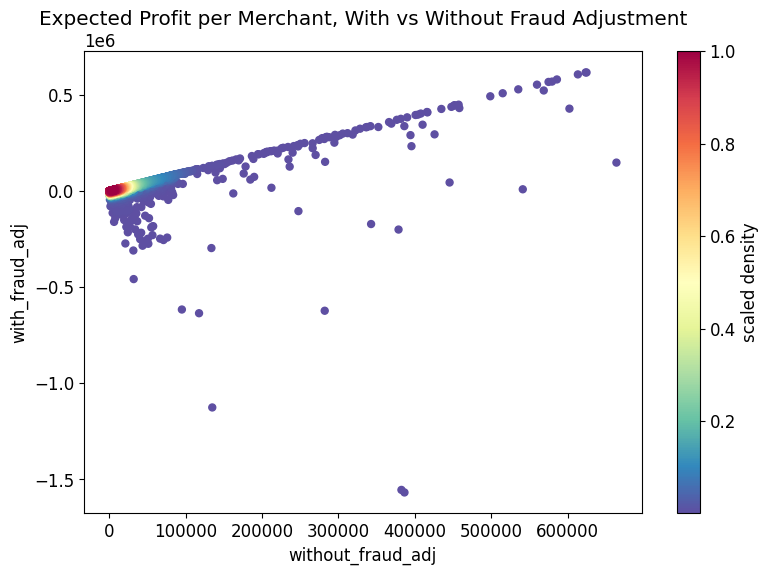

In [13]:
# plot expected profitability per merchant, before and after fraud adjustment
# a linear relationship = minimal fraud impactr
merchant_revenue_all = merchant_revenue.merge(merchant_revenue_fraud, on="merchant_abn")
merchant_revenue_all = merchant_revenue_all.rename(columns={'total_revenue_x': 'without_fraud_adj', 'total_revenue_y': 'with_fraud_adj'})

merchant_revenue_all = merchant_revenue.merge(merchant_revenue_fraud, on="merchant_abn")
merchant_revenue_all = merchant_revenue_all.rename(columns={'total_revenue_x': 'without_fraud_adj', 'total_revenue_y': 'with_fraud_adj'})

sc_plot = scatter_density(merchant_revenue_all, 'without_fraud_adj', 'with_fraud_adj', 'Expected Profit per Merchant, With vs Without Fraud Adjustment')
sc_plot.savefig(f'{PLOTS}fraud_scatter2.png', bbox_inches='tight')

It can be seen that some merchants have negative expected profitability after adjusting for fraud, however there are still a number of merchants that have high expected profitability. In fact most merchants do not suffer a large impact to expected profitability due to fraud adjustment. The apparent higher rate of merchants impacted by fraud at lower profit levels, can be explained entirely by the greater density of merchants with lower revenue in general.


### Rank Merchants by Expected Profitability

Merchants are ranked by profitability, and then analysis conducted into what features correlate to higher ranked merchants

In [14]:
# add ranks
merchant_revenue_fraud['rank'] = merchant_revenue_fraud['total_revenue'].rank(ascending=False)
merchant_revenue_fraud = merchant_revenue_fraud.sort_values('rank')

# aggregate daily transactions per merchant
merchant_daily_revenue = transactions_fraud.groupBy('merchant_abn', 'order_datetime').agg(
    F.count(F.col("order_id")).alias("num_daily_orders"),
    F.sum('dollar_value').alias('daily_revenue')
)

merchant_daily_revenue = merchant_daily_revenue.groupBy('merchant_abn').agg(
    F.avg("num_daily_orders").alias("avg_daily_orders"),
    F.avg('daily_revenue').alias('avg_daily_revenue'),
    F.stddev('daily_revenue').alias('sd_daily_revenue'),
)

# save down merchant ranking according to expected profitability
merchant_daily_revenue = merchant_daily_revenue.toPandas().merge(merchant_revenue_fraud, on="merchant_abn", how="inner")
merchant_daily_revenue.to_pickle(f"{ANALYSIS_DATA}revenue_fraud_ranking.pkl")


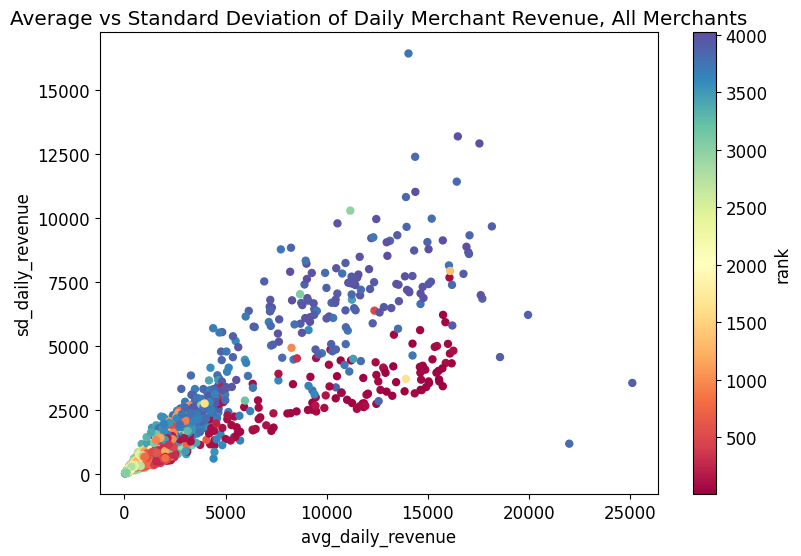

In [15]:
# examine average daily revenue per merchant, against variability in this daily revenue

# take all merchants
merchant_daily_subset = merchant_daily_revenue.loc[merchant_daily_revenue["rank"]<=5000,]
# randomise the order of data so that the scatterplot correctly shows density
merchant_daily_subset= merchant_daily_subset.sample(frac=1)

plot = merchant_daily_subset.plot.scatter(
        x='avg_daily_revenue', y='sd_daily_revenue',
        title = "Average vs Standard Deviation of Daily Merchant Revenue, All Merchants", 
        c='rank', cmap='Spectral', s=25)
    #plot.set_xlabel("population")
fig = plot.get_figure()
fig.set_size_inches(9, 6)
fig.savefig(f'{PLOTS}merch_rev1.png', bbox_inches='tight')

These scatter plots show the highly ranked merchants in red, and lower ranked merchants in blue, both with average daily revenue on the x-axis. Clearly higher daily revenue is good, but only if variability in daily revenue is low, as seen above

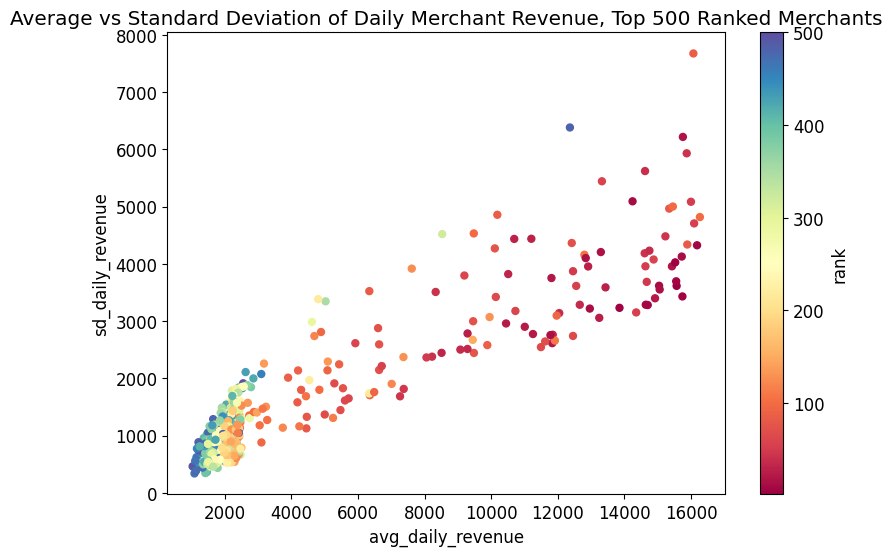

In [16]:
# look at the top 500 merchants only
merchant_daily_subset = merchant_daily_revenue.loc[merchant_daily_revenue["rank"]<=500,]
# randomise the order of data so that the scatterplot correctly shows density
merchant_daily_subset= merchant_daily_subset.sample(frac=1)

plot = merchant_daily_subset.plot.scatter(
        x='avg_daily_revenue', y='sd_daily_revenue',
        title = "Average vs Standard Deviation of Daily Merchant Revenue, Top 500 Ranked Merchants", 
        c='rank', cmap='Spectral', s=25)
    #plot.set_xlabel("population")
fig = plot.get_figure()
fig.set_size_inches(9, 6)

In this next section we examine whether the composition of merchant revenue (revenue generated mostly from small < $1500 sized transactions, or large transactions) has a large impact on ranking, given the different distributions underpinning these two segments

In [17]:
# aggregate daily transactions per consumer, so can flag as below or above 1500 -> do merchants who have smaller or larger transactions end up with better pnl?
consumer_daily_spend = transactions_fraud.groupBy('user_id', 'order_datetime').agg(    
    F.sum('dollar_value').alias('total_spend')
)
# set a flag for whether total user spend for the day is less than 1500, or greater
consumer_daily_spend = consumer_daily_spend.withColumn('small_spend',
                       consumer_daily_spend.total_spend <= 1500)

# bring in small spend flag
merchant_small_revenue = transactions_fraud.join(consumer_daily_spend.select('user_id', 'order_datetime', 'small_spend'),
                                                 on=(['user_id', 'order_datetime']), how='inner')

# only keep small spend and aggregate numbers
merchant_small_revenue = merchant_small_revenue.filter(merchant_small_revenue.small_spend==True)

merchant_small_revenue = merchant_small_revenue.groupBy('merchant_abn', 'order_datetime').agg(
    F.count(F.col("order_id")).alias("num_daily_orders"),
    F.sum('dollar_value').alias('daily_revenue')
)

merchant_small_revenue = merchant_small_revenue.groupBy('merchant_abn').agg(
    F.avg("num_daily_orders").alias("avg_daily_orders"),
    F.avg('daily_revenue').alias('avg_daily_revenue'),
    F.stddev('daily_revenue').alias('sd_daily_revenue'),
)

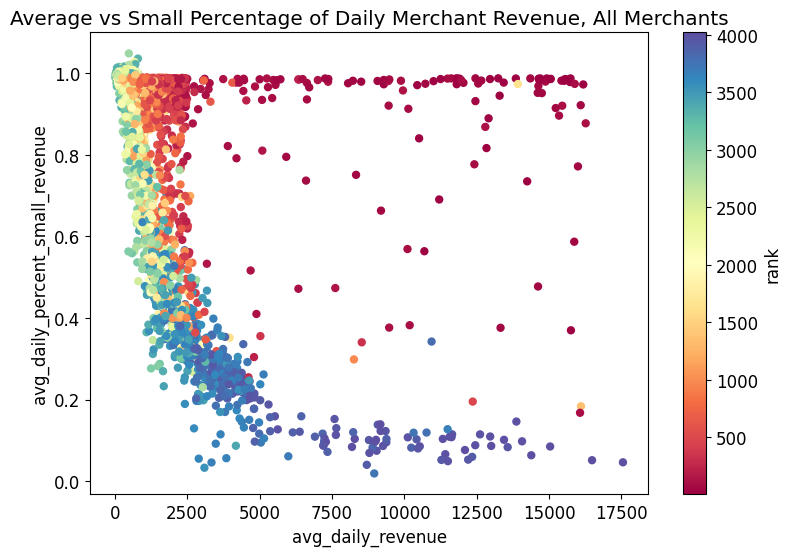

In [18]:
# now want to plot average daily revenue, against the % of daily revenue which comes from small transactions

merchant_compare = merchant_small_revenue.toPandas()
del transactions_fraud
del merchant_small_revenue

merchant_compare = merchant_compare.merge(merchant_daily_revenue, on="merchant_abn", how="inner")
# calculate the percentage of daily revenue which comes from small transactions
merchant_compare["avg_daily_percent_small_revenue"] = merchant_compare["avg_daily_revenue_x"]/merchant_compare["avg_daily_revenue_y"]

merchant_compare = merchant_compare.rename(columns={'avg_daily_revenue_y': 'avg_daily_revenue'})
merchant_daily_subset= merchant_compare.sample(frac=1)

plot = merchant_daily_subset.plot.scatter(
        x='avg_daily_revenue', y='avg_daily_percent_small_revenue',
        title = "Average vs Small Percentage of Daily Merchant Revenue, All Merchants", 
        c='rank', cmap='Spectral', s=25)
    #plot.set_xlabel("population")
fig = plot.get_figure()
fig.set_size_inches(9, 6)
fig.savefig(f'{PLOTS}merch_rev2.png', bbox_inches='tight')

The chart above shows that merchants which generated nearly all their revenue from small transactions were also generally favoured. Fraud probability is key to this finding, and it should be reiterated that the majority of small transactions attract zero fraud probability

### Best vs Worst Merchants

In this final section we examine what the average expected profit and distribution looks like for the top vs bottom ranked merchants

average top revenue: 288181.3180851563
average bottom revenue: -23064.078184677946


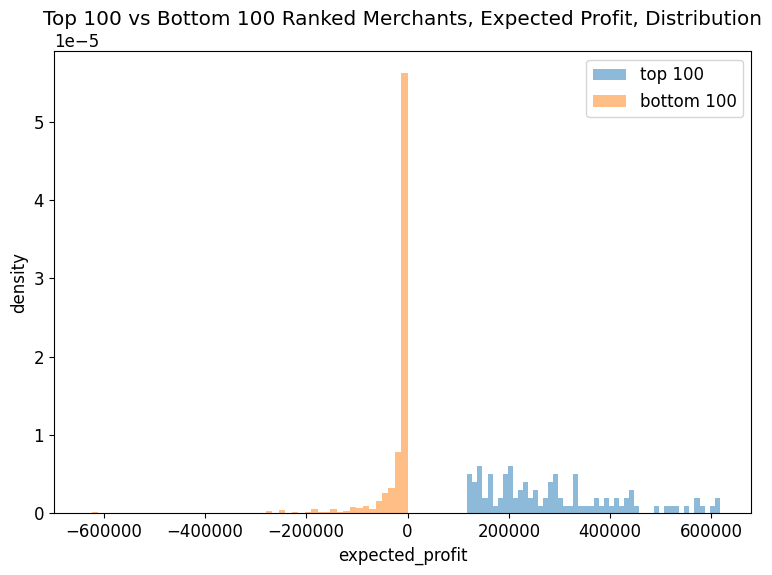

In [19]:
# get the top 100 and bottom 100 merchants, ranked by expected profitability
merchant_rank_high = merchant_daily_revenue.loc[merchant_daily_revenue["rank"]<=100,]
merchant_rank_low = merchant_daily_revenue.loc[merchant_daily_revenue["rank"]>=3253,]
# remove an outlier
merchant_rank_low = merchant_rank_low.loc[merchant_rank_low["total_revenue"]>-1000000,]

print(f"average top revenue: {merchant_rank_high['total_revenue'].mean()}")
print(f"average bottom revenue: {merchant_rank_low['total_revenue'].mean()}")

plt.figure(figsize=(9, 6))
plt.hist(list(merchant_rank_high["total_revenue"]), bins=50, alpha=0.5, label="top 100", density=True)
plt.hist(list(merchant_rank_low["total_revenue"]), bins=50, alpha=0.5, label="bottom 100", density=True)
plt.title('Top 100 vs Bottom 100 Ranked Merchants, Expected Profit, Distribution')
plt.xlabel('expected_profit')
plt.ylabel('density')
#plt.ylabel('count')
plt.legend()
plt.savefig(f'{PLOTS}top_v_bottom.png', bbox_inches='tight')
plt.show()
